# 이미지 로드 및 전처리하기

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.6.0


In [5]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 7s 0us/step


In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


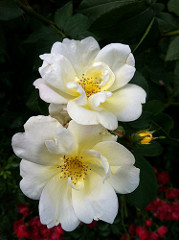

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

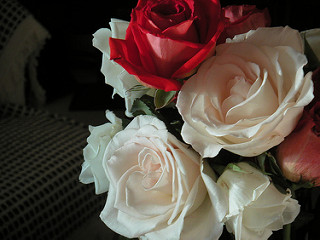

In [8]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


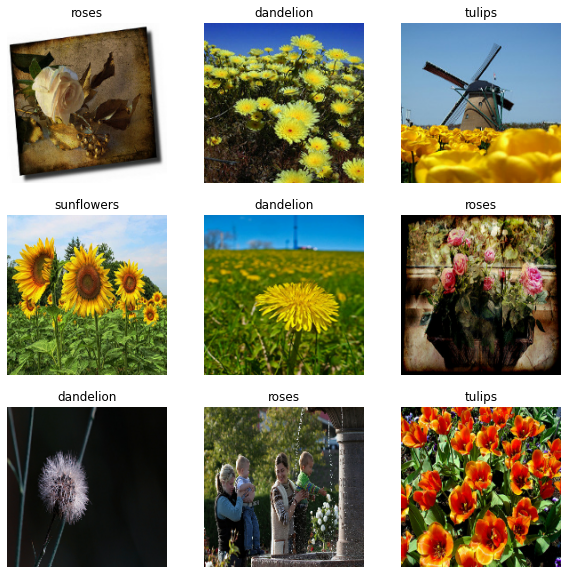

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [15]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [19]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [20]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 11s 44ms/step - loss: 1.3081 - accuracy: 0.4567 - val_loss: 1.0937 - val_accuracy: 0.5695
Epoch 2/3
92/92 [==============================] - 2s 21ms/step - loss: 1.0074 - accuracy: 0.6046 - val_loss: 0.9631 - val_accuracy: 0.6158
Epoch 3/3
92/92 [==============================] - 2s 21ms/step - loss: 0.8437 - accuracy: 0.6683 - val_loss: 0.9172 - val_accuracy: 0.6349


In [21]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [22]:
for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\bitcamp\\.keras\\datasets\\flower_photos\\dandelion\\8220011556_28e0cab67f.jpg'
b'C:\\Users\\bitcamp\\.keras\\datasets\\flower_photos\\tulips\\17159349572_c0c51599f7_n.jpg'
b'C:\\Users\\bitcamp\\.keras\\datasets\\flower_photos\\dandelion\\6012046444_fd80afb63a_n.jpg'
b'C:\\Users\\bitcamp\\.keras\\datasets\\flower_photos\\roses\\5578760521_e54aca6bed_n.jpg'
b'C:\\Users\\bitcamp\\.keras\\datasets\\flower_photos\\tulips\\112650879_82adc2cc04_n.jpg'


In [23]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [24]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [25]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [26]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [27]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [28]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [29]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [30]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


In [31]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

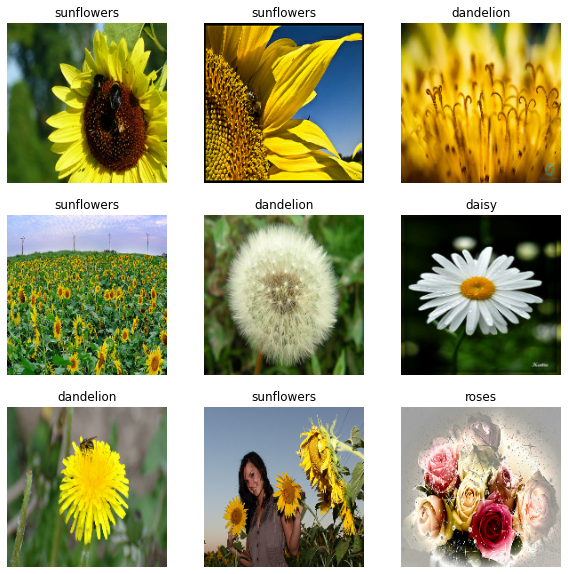

In [32]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [33]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 3s 27ms/step - loss: 0.7024 - accuracy: 0.7340 - val_loss: 0.7730 - val_accuracy: 0.7098
Epoch 2/3
92/92 [==============================] - 2s 22ms/step - loss: 0.5265 - accuracy: 0.8048 - val_loss: 0.6800 - val_accuracy: 0.7411
Epoch 3/3
92/92 [==============================] - 2s 23ms/step - loss: 0.3439 - accuracy: 0.8767 - val_loss: 0.8735 - val_accuracy: 0.7084


In [34]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling ~\tensorflow_datasets\tf_flowers\3.0.1.incomplete2NWOVH\tf_flowers-train.tfrecord*...:   0%|        …

Dataset tf_flowers downloaded and prepared to ~\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [35]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


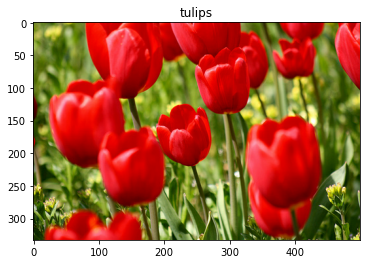

In [36]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [37]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)